In [65]:
#import our libraries
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics

In [66]:
#read data and set index
df=pd.read_excel(r"C:\Users\Chiselas\FarmerSegmentationClean1.xlsx")
df= df.set_index(df.columns[0])

In [67]:
#create new dataframe for the selected 3 columns(attributes) and rename column names to generic columns 
def Load_data():
    
    data=df[df.columns[0:3]]
    old_names=data.columns.values[0:3]
    new_names=['col1', 'col2', 'col3']
    data.rename(columns=dict(zip(old_names, new_names)), inplace=True)
    return data

In [68]:
data=Load_data()
data.head()

C:\Users\Chiselas\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,col1,col2,col3
HH_Id,,,
1406,0.666667,100.000000,33333.333333
306,0.166667,4.000000,333.333333
201,0.000000,2.000000,0.000000
303,0.692308,43.333333,15000.000000
203,0.571429,21.875000,0.000000


In [69]:
#Create statistics table to deal with outliers
data_stats= data.describe()
data_stats=data_stats.T
max_val= data_stats['max']
qrt_75= data_stats['75%']
#create determinant column to determine which outlier elimination method needs to be applied
data_stats['det']=qrt_75/max_val

#Set the conditions and the elimination choices
conditions= [(data_stats['det']<= 0.1),
        (data_stats['det']>0.1) & (data_stats['det']<= 0.75),
        (data_stats['det']>0.75)]
choices=[(max_val-3*(data_stats['std'])),
        (max_val-data_stats['std']),
        (max_val)]

#Apply the conditions and choices to new column called Cutoff
data_stats['Cutoff']=np.select(conditions, choices)
cutoff1= data_stats.loc['col1','Cutoff']
cutoff2= data_stats.loc['col2','Cutoff']
cutoff3= data_stats.loc['col3','Cutoff']

In [70]:
print(cutoff1)
print(cutoff2)
print(cutoff3)

0.6579597740908252
381.73459531534604
54788.495927372176


In [71]:
data_stats

,count,mean,std,min,25%,50%,75%,max,det,Cutoff
col1,376.0,0.432202,0.342040,0.0,0.000000,0.500000,0.714286,1.000000,0.714286,0.657960
col2,376.0,62.428463,68.265405,0.0,15.721154,37.697368,90.000000,450.000000,0.200000,381.734595
col3,376.0,11356.287552,16878.170739,0.0,0.000000,2803.571429,15340.909091,71666.666667,0.214059,54788.495927


In [72]:
#Create two seperate dataframes based on the outlier cutoffs
outlier=data[(data['col1']>= cutoff1) | (data['col2']>= cutoff2) | (data['col3']>= cutoff3)]
  

In [73]:
data_filtered=data[(data['col1']< cutoff1) & (data['col2']< cutoff2) & (data['col3']< cutoff3)]

In [74]:
data_filtered

,col1,col2,col3
HH_Id,,,
306,0.166667,4.000000,333.333333
201,0.000000,2.000000,0.000000
203,0.571429,21.875000,0.000000
2601,0.000000,15.833333,0.000000
2605,0.186567,76.571429,0.000000
...,...,...,...
9405,0.000000,0.000000,0.000000
8806,0.142857,23.333333,1666.666667
6301,0.000000,200.000000,0.000000


In [75]:
#Scale both datasets using Robust Scaler which will further handle any outliers
robust_scaler=RobustScaler()
scaled_data= robust_scaler.fit_transform(data_filtered)
scaled_outlier= robust_scaler.transform(outlier)

In [76]:
#Use KMeans to create clusters
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000,  random_state=0)
KMean_clust.fit(scaled_data)

#Find the clusters for the observation given in the dataset
filtered_clusters = KMean_clust.fit_predict(scaled_data)
outlier_clusters = KMean_clust.predict(scaled_outlier)
data_filtered['Cluster']=filtered_clusters
outlier['Cluster']=outlier_clusters
combined_data=data_filtered.append(outlier)

<ipython-input-76-52c702126234>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Cluster']=filtered_clusters
<ipython-input-76-52c702126234>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier['Cluster']=outlier_clusters


In [77]:
data_filtered

,col1,col2,col3,Cluster
HH_Id,,,,
306,0.166667,4.000000,333.333333,0
201,0.000000,2.000000,0.000000,0
203,0.571429,21.875000,0.000000,0
2601,0.000000,15.833333,0.000000,0
2605,0.186567,76.571429,0.000000,0
...,...,...,...,...
9405,0.000000,0.000000,0.000000,0
8806,0.142857,23.333333,1666.666667,0
6301,0.000000,200.000000,0.000000,2


In [78]:
model= KMean_clust.fit(scaled_data)

In [ ]:
#save model for web app
import pickle
pickle.dump(model, open("kmeans_model.pkl", "wb"))

In [82]:
#Copy Cluster column to df
df['Cluster']=combined_data['Cluster']

In [83]:
#Create Scoring table to rank the clusters according to performance on each attribute.
Scoring_table=combined_data.groupby('Cluster')['col1', 'col2', 'col3'].mean()
Scoring_table=Scoring_table.rank(axis=0, method='max')
Scoring_table['Score']=Scoring_table['col1'] + Scoring_table['col2'] + Scoring_table['col3']

#Assign Profile tiers to each Cluster
def Profile(val):
    if val == Scoring_table['Score'].max():
        
        return 'Top Tier'
    elif val == Scoring_table['Score'].min():
        return 'Lower Tier'
    else:
        return 'Middle Tier'
    


<ipython-input-83-9f00cb5c9242>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Scoring_table=combined_data.groupby('Cluster')['col1', 'col2', 'col3'].mean()


In [85]:
Scoring_table['Profile']= Scoring_table['Score'].apply(Profile)
Scoring_table

,col1,col2,col3,Score,Profile
Cluster,,,,,
0,1.0,1.0,2.0,4.0,Lower Tier
1,3.0,2.0,3.0,8.0,Top Tier
2,2.0,3.0,1.0,6.0,Middle Tier


In [86]:
#Create profile dictionary to apply to df
profile_dict= Scoring_table.to_dict()['Profile']
profile_dict

{0: 'Lower Tier', 1: 'Top Tier', 2: 'Middle Tier'}

In [87]:
def set_value(row_number, assigned_value):
    return assigned_value[row_number]

df['Profile']=df['Cluster'].apply(set_value, args=(profile_dict, ))

In [88]:
df.head()

,Beans_sldprt,Yield_pracr,Rev_pracr,District,HH_Sex,HHSize_16-65,Farmer_orgs,FarmSize_Own,Land_owned,Land_farmed,...,Times_beans_sold,Rev_ReInv_Farm,Agric_Inputs_rec,Ag_Credit_rec,Ask_Advice,AgExW_Contact,Agric_PrSrceInc,MultipleIncSrce,Cluster,Profile
HH_Id,,,,,,,,,,,,,,,,,,,,,
1406,0.666667,100.000000,33333.333333,1,M,2.0,No,1.500,6.0,1.5,...,1.0,No,Yes,No,Yes,Yes,Yes,Yes,1,Top Tier
306,0.166667,4.000000,333.333333,2,M,4.0,Yes,15.000,25.0,15.0,...,1.0,No,Yes,Yes,Yes,Yes,Yes,Yes,0,Lower Tier
201,0.000000,2.000000,0.000000,2,F,3.0,Yes,5.000,10.0,5.0,...,0.0,NaN,Yes,No,Yes,Yes,Yes,Yes,0,Lower Tier
303,0.692308,43.333333,15000.000000,2,M,2.0,No,0.375,2.0,1.5,...,2.0,No,No,No,Yes,Yes,Yes,No,1,Top Tier
203,0.571429,21.875000,0.000000,2,M,2.0,Yes,8.000,15.0,8.0,...,0.0,NaN,Yes,No,Yes,Yes,Yes,No,0,Lower Tier


In [89]:
df["Profile"].value_counts()

Lower Tier     247
Top Tier       103
Middle Tier     26
Name: Profile, dtype: int64

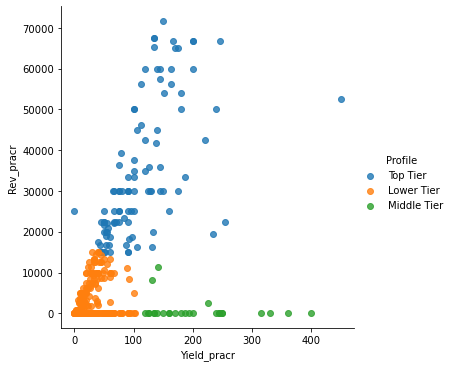

In [91]:
sns.lmplot(x='Yield_pracr', y='Rev_pracr', hue='Profile', fit_reg=False, data=df)

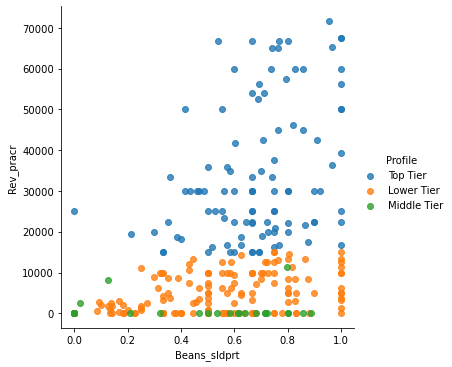

In [92]:
sns.lmplot(x='Beans_sldprt', y='Rev_pracr', hue='Profile', fit_reg=False, data=df)